## Forecast intra-day vehicular traffic trend using Seasonal ARIMA

### Our data contains hourly data with multiple seasonalities - daily as well as weekly

#### Autoregressive integrated moving average (ARIMA) models are used to model time series data, however to deal with multiple seasonality, external regressors need to be added to the ARIMA model. To incorporate the multiple seasonality in our gamer login behavior, we have added Fourier terms as external regressors to the ARIMA model, where Nt is an ARIMA process.

#### To derive the right number of Fourier terms corresponding to each of the periods, we need to calculate the AIC values of the ARIMA model with varying Fourier terms. The scatter plot above shows the AIC values with varying number of Fourier terms for the two periods. Our example suggests we can best minimize the AIC criteria with one Fourier term corresponding to a period of 24 hours (to model intra-day vehicular traffic) and two Fourier terms corresponding to a period of 168 hours(to model intra-week vehicular traffic - 24*7).

In [2]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
#load the data
data = pd.read_csv('D:\\Study\\DataScience\\Data\\MachineLearningData\\TrafficData\\hourlydata.csv')

In [26]:
# Convert the Index to DatetimeIndex
data.index = pd.to_datetime(data.index)

In [27]:
# Resample the hourly data into daily data
data_daily = data.resample('H').sum()

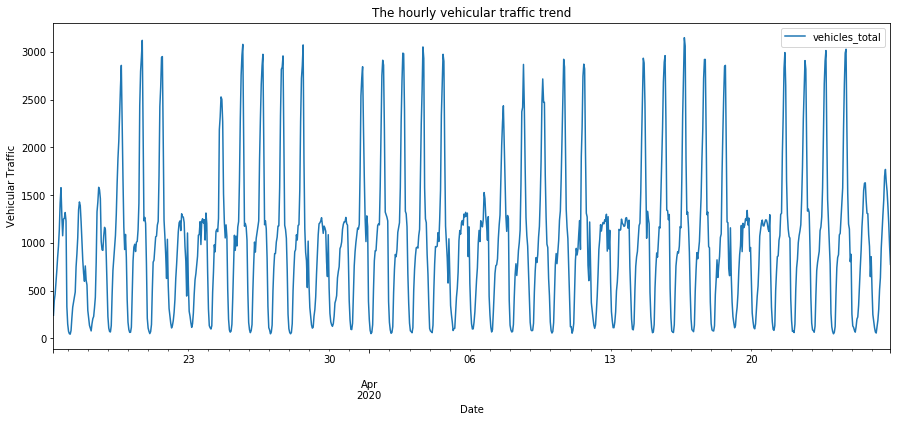

In [28]:
# Plot the dataframe to visualize time series data
data_daily.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Vehicular Traffic')
plt.title('The hourly vehicular traffic trend')
plt.show()

# Use SARIMAX with Fourier Terms to analyse multiple seasonalities

In [8]:
# Import statmdoels for timeseries
import statsmodels.api as sm

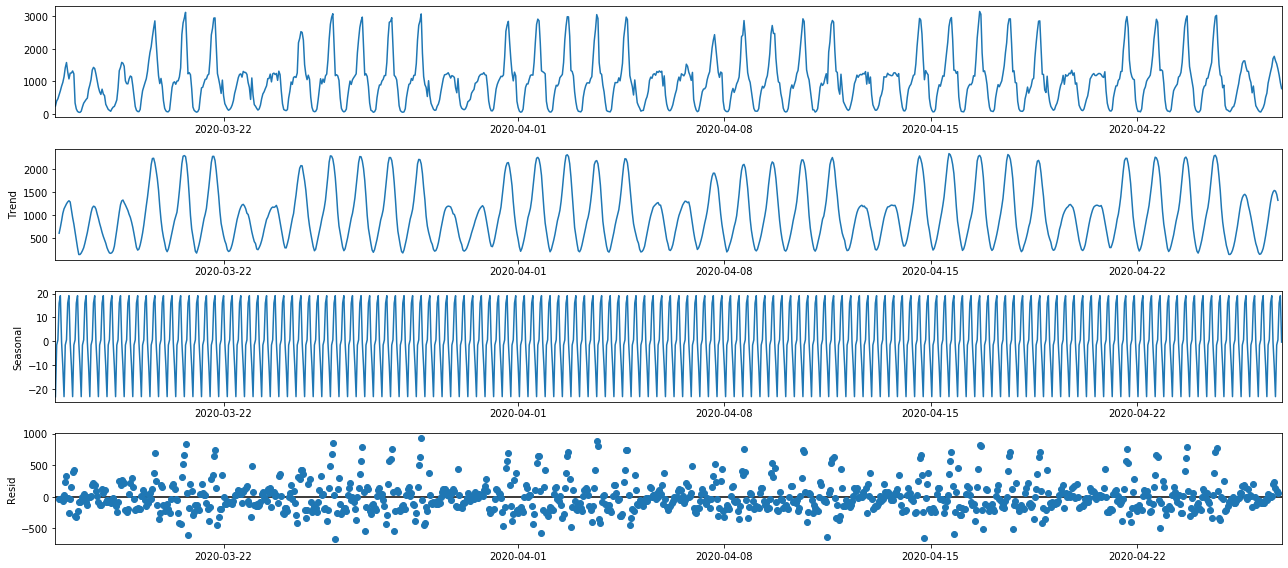

In [26]:
# Use decomposition method to visualize the various components of time series data
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data_daily, model='additive', freq = 7)
fig = decomposition.plot()
plt.show()

In [20]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(data['vehicles_total'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.857977
p-value                          0.050458
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary. This confirms our original observation which we initially saw in the visual test.

In [25]:
from pmdarima import auto_arima
arima_model = auto_arima(y_to_train, seasonal=True, m=24)
y_arima_forecast = arima_model.predict(n_periods=48)

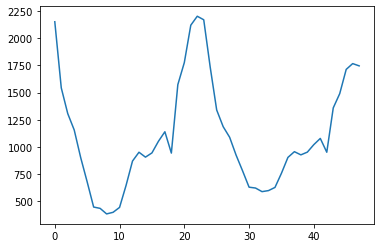

In [24]:
plt.plot(y_arima_forecast)

In [30]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  635
Model:             SARIMAX(1, 0, 4)x(1, 0, [], 24)   Log Likelihood               -4299.462
Date:                             Mon, 04 May 2020   AIC                           8614.924
Time:                                     13:18:35   BIC                           8650.553
Sample:                                          0   HQIC                          8628.758
                                             - 635                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    140.0065     32.469      4.312      0.000      76.369     203.644
ar.L1          0.5887      0.072      8.229      0.000       0.448       0.729
ma.L1          0.4426      0.073      6.046      0.000       0.299       0.586
ma.L2          0.3405      0.081      4.184      0.000       0.181       0.500
ma.L3          0.2430      0.077      3.141      0.002       0.091       0.395
ma.L4          0.1065      0.059      1.795      0.073      -0.010       0.223
ar.S.L24       0.6477      0.023     28.200      0.000       0.603       0.693
sigma2      4.351e+04   1511.065     28.792      0.000    4.05e+04    4.65e+04
===================================================================================
Ljung-Box (Q):                       95.86   Jarque-Bera (JB):               443.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.31
Prob(H) (two-sided):                  0.80   Kurtosis:                         7.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h3>Auto arima has chosen SARIMA(0, 1, 4)x(1, 0, 4, 24) model. As expected weekly pattern is not modeled.</h3>

In [ ]:
# prepare Fourier terms
exog = pd.DataFrame({'date': y.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='H'))
exog['sin168'] = np.sin(2 * np.pi * exog.index.dayofyear / 168)
exog['cos168'] = np.cos(2 * np.pi * exog.index.dayofyear / 168)
exog['sin168_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 168)
exog['cos168_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 168)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(y)-365)]
exog_to_test = exog.iloc[(len(y)-365):]
# Fit model
arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=24)
# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=365, exogenous=exog_to_test)

In [67]:
exog = pd.DataFrame({'date': y.index})

In [75]:
y = data['vehicles_total']

In [76]:
y_to_train = y.iloc[:(len(y)-336)]
y_to_test = y.iloc[(len(y)-336):] # last couple weeks for testing

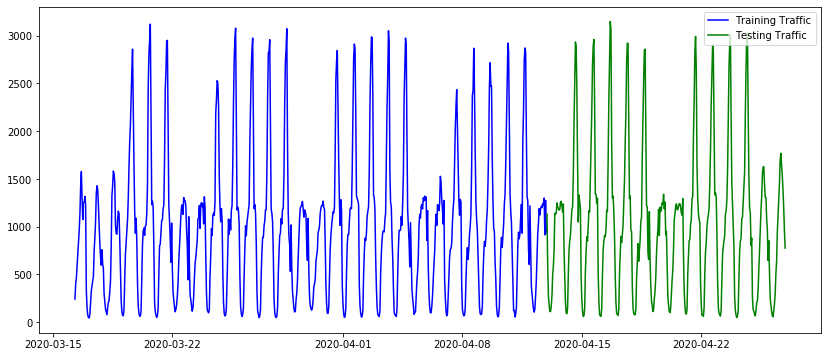

In [92]:
plt.figure(figsize=(14,6))
plt.plot(y_to_train, 'b-', label='Training Traffic')
plt.plot(y_to_test, 'g', label='Testing Traffic')
plt.legend(loc='upper right', frameon=True)
plt.show()

In [93]:
from pmdarima import auto_arima
arima_model = auto_arima(y_to_train, seasonal=True, m=24)
y_arima_forecast = arima_model.predict(n_periods=336)

In [106]:
dt = pd.date_range("2020-04-12 23:00:00", "2020-04-26 22:00:00", freq="60min")

In [112]:
predict = pd.DataFrame(index=dt, data=y_arima_forecast)
predict.columns = ['vehicular_total']

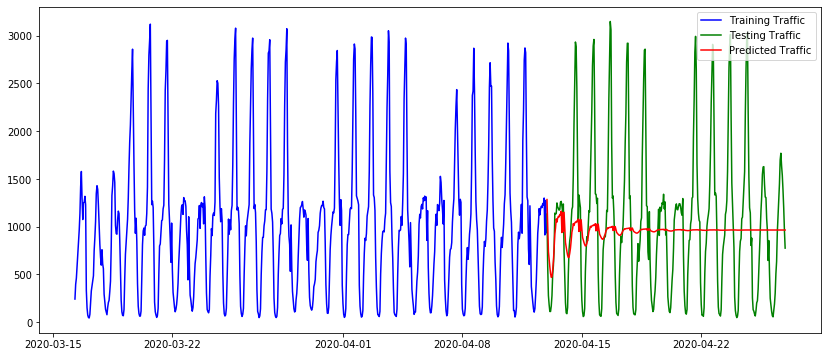

In [116]:
plt.figure(figsize=(14,6))
plt.plot(y_to_train, 'b-', label='Training Traffic')
plt.plot(y_to_test, 'g', label='Testing Traffic')
plt.plot(predict, 'r', label='Predicted Traffic')
plt.legend(loc='upper right', frameon=True)
plt.show()

In [122]:
# prepare Fourier terms
exog = pd.DataFrame({'time': y.index})

In [123]:
exog

,time
0,2020-03-16 07:00:00
1,2020-03-16 08:00:00
2,2020-03-16 09:00:00
3,2020-03-16 10:00:00
4,2020-03-16 11:00:00
...,...
995,2020-04-26 18:00:00
996,2020-04-26 19:00:00
997,2020-04-26 20:00:00
998,2020-04-26 21:00:00


In [125]:
exog = exog.set_index(pd.PeriodIndex(exog['time'], freq='H'))

In [128]:
exog.index.hour

Int64Index([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            ...
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
           dtype='int64', name='time', length=1000)

In [163]:
exog['sin365'] = np.sin(2 * np.pi * exog.index.hour/24*7)
exog['cos365'] = np.cos(2 * np.pi * exog.index.hour/24*7)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.hour/24*7)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.hour/24*7)
#exog = exog.drop(columns=['time'])
exog_to_train = exog.iloc[:(len(y)-336)]
exog_to_test = exog.iloc[(len(y)-336):]

In [164]:
exog

,sin365,cos365,sin365_2,cos365_2
time,,,,
2020-03-16 07:00,0.258819,9.659258e-01,5.000000e-01,8.660254e-01
2020-03-16 08:00,0.866025,-5.000000e-01,-8.660254e-01,-5.000000e-01
2020-03-16 09:00,-0.707107,-7.071068e-01,1.000000e+00,-4.904777e-16
2020-03-16 10:00,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01
2020-03-16 11:00,0.965926,2.588190e-01,5.000000e-01,-8.660254e-01
...,...,...,...,...
2020-04-26 18:00,1.000000,-4.904777e-16,-9.809554e-16,-1.000000e+00
2020-04-26 19:00,-0.258819,-9.659258e-01,5.000000e-01,8.660254e-01
2020-04-26 20:00,-0.866025,5.000000e-01,-8.660254e-01,-5.000000e-01


In [165]:
# Fit model
arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=24)

In [166]:
# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=336, exogenous=exog_to_test)

In [168]:
dp = pd.date_range("2020-04-12 23:00:00", "2020-04-26 22:00:00", freq="60min")
dpr = pd.DataFrame(index=dp, data=y_arima_exog_forecast)
dpr.columns = ['vehicular_total']

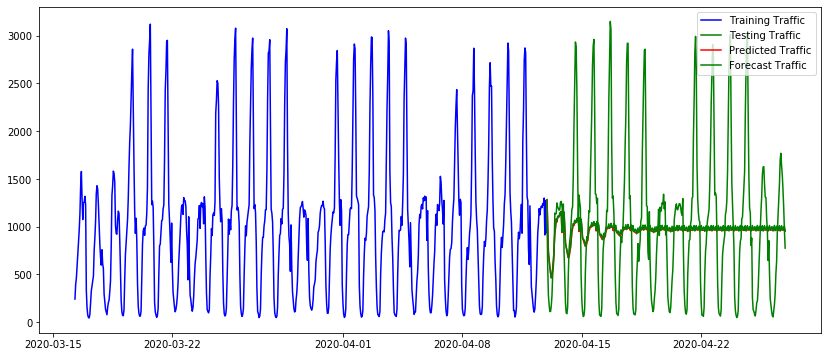

In [169]:
plt.figure(figsize=(14,6))
plt.plot(y_to_train, 'b-', label='Training Traffic')
plt.plot(y_to_test, 'g', label='Testing Traffic')
plt.plot(predict, 'r', label='Predicted Traffic')
plt.plot(dpr, 'g', label='Forecast Traffic')
plt.legend(loc='upper right', frameon=True)
plt.show()